<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/Forecasting/Semiconductor/%EB%B0%98%EB%8F%84%EC%B2%B4_%EC%A0%9C%EC%A1%B0_%EA%B3%B5%EC%A0%95_%ED%94%84%EB%A1%9C%EC%84%B8%EC%8A%A4_pass_fail_%EC%88%98%EC%9C%A8_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Information
<hr>
* 실험은 가스 터빈 추진 장치를 특징으로 하는 해군 함정의 수치 시뮬레이터를 통해 수행됨.
완전한 시뮬레이터 (Properller, Hull, GT, Gear Box 및 Controller)를 구성하는 다양한 블록이 여러 유사한 실제 추진 플랜트에서 개발되고 미세 조정됨.
이런 관찰을 고려할 때 사용 가능한 데이터는 가능한 실제 선박과 일치합니다.


이 시뮬레이터 릴리스에서는 GT 압축기 및 터빈과 같은 GT 구성 요소의 시간 경과에 따른 성능 저하를 고려 할 수 있음

###The propulsion system behaviour has been described with this parameters:
* Ship spped :: 선속 (linear function of the lever position lp).
* Compressor degradation coefficient kMc.(압축기 열화 계수)
* Turbine degradation coefficiednt kMt.(터빈열화계수)

각 가능한 열화 상태는 lp, kMt, kMc의 조합으로 설명될 수 있음.


###Attribute Information :
A 16-feature vector containing the GT measures at steady state of the physical asset:
* Lever position (lp) [ ]
* Ship spped (v) [knots]
* Gas Turbine (GT) shaft torque (GTT) [kN m]
* GT rate of revolutions (GTn) [rpm]
* Gas Generator rate of revolutions (GGn) [rpm]
* Starboard Propeller Torque (Ts) [kN]
* Port Propeller Torque (Tp) [kN]
* Hight Pressure (HP) Turbine exit temperature (T48) [C]
* GT Compressor inlet air temperature (T1) [C]
* GT Compressor outlet air temperature (T2) [C]
* HP Turbine exit pressure (P48) [bar]
* GT Compressor inlet air pressure (P1) [bar]
* GT Compressor outlet air pressure (P2) [bar]
* GT exhaust gas pressure (Pexh) [bar]
* Turbine injection Control (TIC) [%]
* Fuel flow (mf) [kg/s]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 01. Data EDA and Preprocessing

<h2> 0. import data

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/uci-secom.csv')
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


# Data Information
* Time : 센서 계측 시간
* 0~589 : 590개 센서 값
* Pass/Fail : 반도체 Wafer 불량 여부 : -1:불량 아님, 1:불량

In [ ]:
data.shape

(1567, 592)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [ ]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


결측치 확인

In [ ]:
data.isnull().any().any()

True

중복값

In [ ]:
print('중복 항목 수 : ',len(data[data.duplicated()]))

중복 항목 수 :  0


# Data Preprocessing

<h2> 1.Missing Values

In [ ]:
data = data.replace(np.NaN, 0)

data.isnull().any().any()

False

<h2> 3. Target Feature Define

In [ ]:
data['Pass/Fail'].unique()

array([-1,  1])

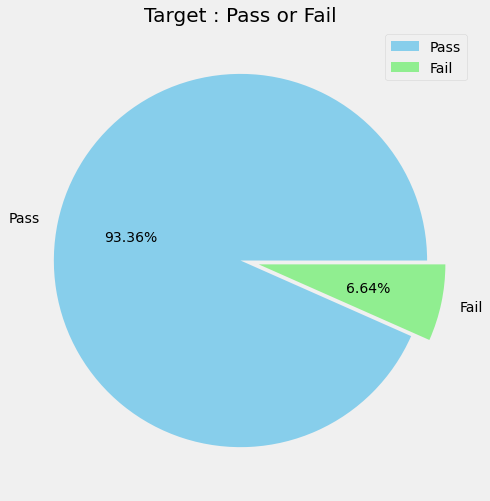

<AxesSubplot:>

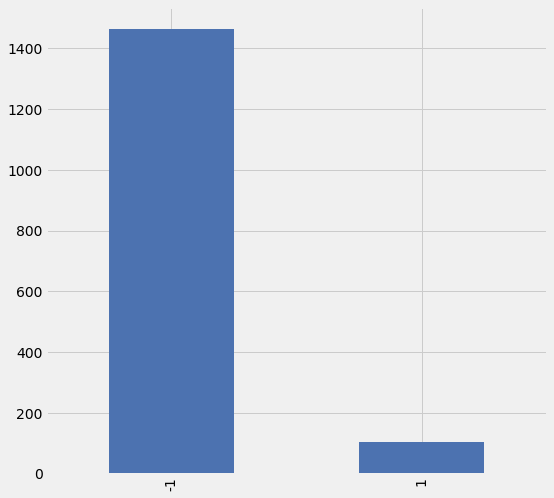

In [ ]:
labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['skyblue', 'lightgreen']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8,8)
plt.pie(size, labels = labels, colors = colors, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Target : Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind='bar')

아주 불균형한 데이터

<h2>2) 각 센서별 Trarget Feature 분포

In [ ]:
unique_vals = data['Pass/Fail'].unique()
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

In [ ]:
print(targets)

[                     Time        0        1          2          3       4  \
0     2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602   
1     2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294   
3     2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204   
4     2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334   
5     2008-07-19 17:53:00  2946.25  2432.84  2233.3667  1326.5200  1.5334   
...                   ...      ...      ...        ...        ...     ...   
1562  2008-10-16 15:13:00  2899.41  2464.36  2179.7333  3085.3781  1.4843   
1563  2008-10-16 20:49:00  3052.31  2522.55  2198.5667  1124.6595  0.8763   
1564  2008-10-17 05:26:00  2978.81  2379.78  2206.3000  1110.4967  0.8236   
1565  2008-10-17 06:01:00  2894.92  2532.01  2177.0333  1183.7287  1.5726   
1566  2008-10-17 06:07:00  2944.92  2450.76  2195.4444  2914.1792  1.5978   

          5         6       7       8  ...       581     582     583     5

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables

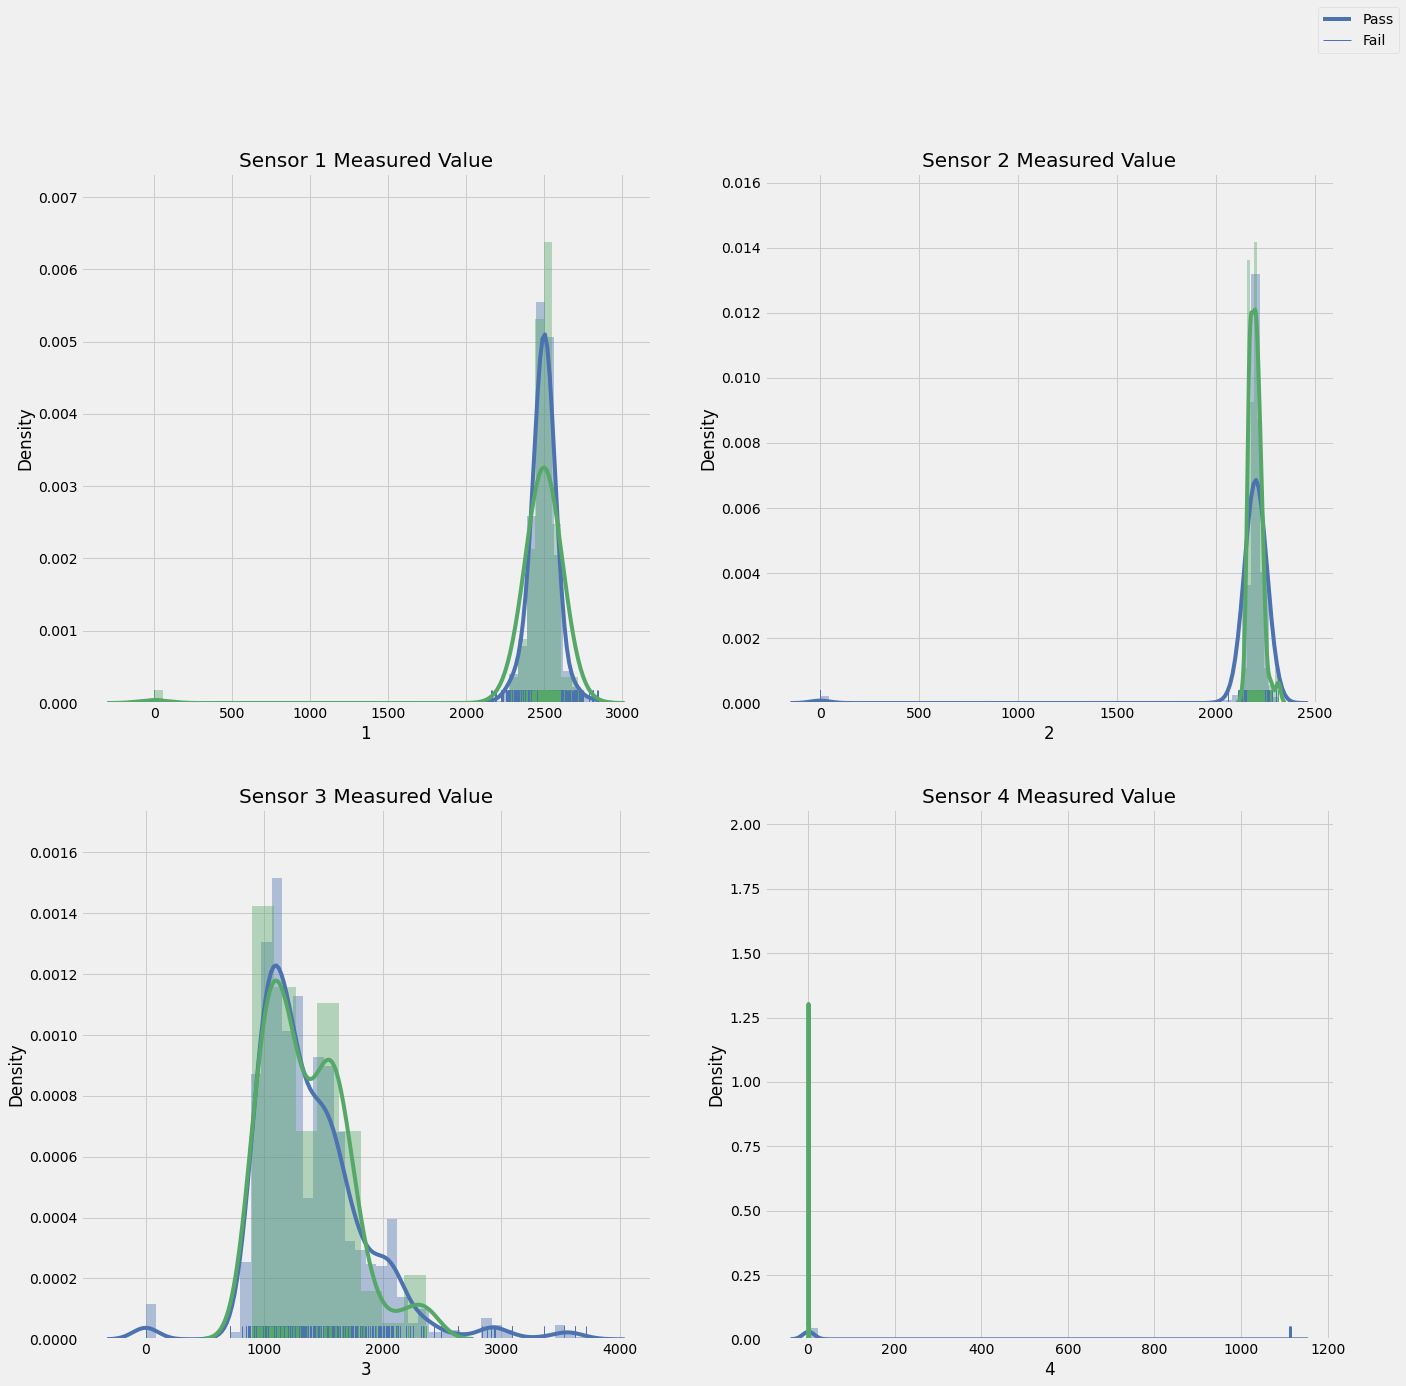

In [ ]:
fig = plt.figure(figsize= (20,20))

plt.subplot(2,2,1)
for target in targets:
  sns.distplot(target['1'], hist=True, rug=True)
plt.title('Sensor 1 Measured Value', fontsize = 20)

plt.subplot(2,2,2)
for target in targets:
  sns.distplot(target['2'], hist=True, rug=True)
plt.title('Sensor 2 Measured Value', fontsize = 20)

plt.subplot(2,2,3)
for target in targets:
  sns.distplot(target['3'], hist=True, rug=True)
plt.title('Sensor 3 Measured Value', fontsize = 20)

plt.subplot(2,2,4)
for target in targets:
  sns.distplot(target['4'], hist=True, rug=True)
plt.title('Sensor 4 Measured Value', fontsize = 20)

fig.legend(labels=['Pass', 'Fail'])
plt.show()

# 4. 연관성에 따른 Feature 정제

<h2> Heat Map

Text(0.5, 1.0, 'Relation HeatMap')

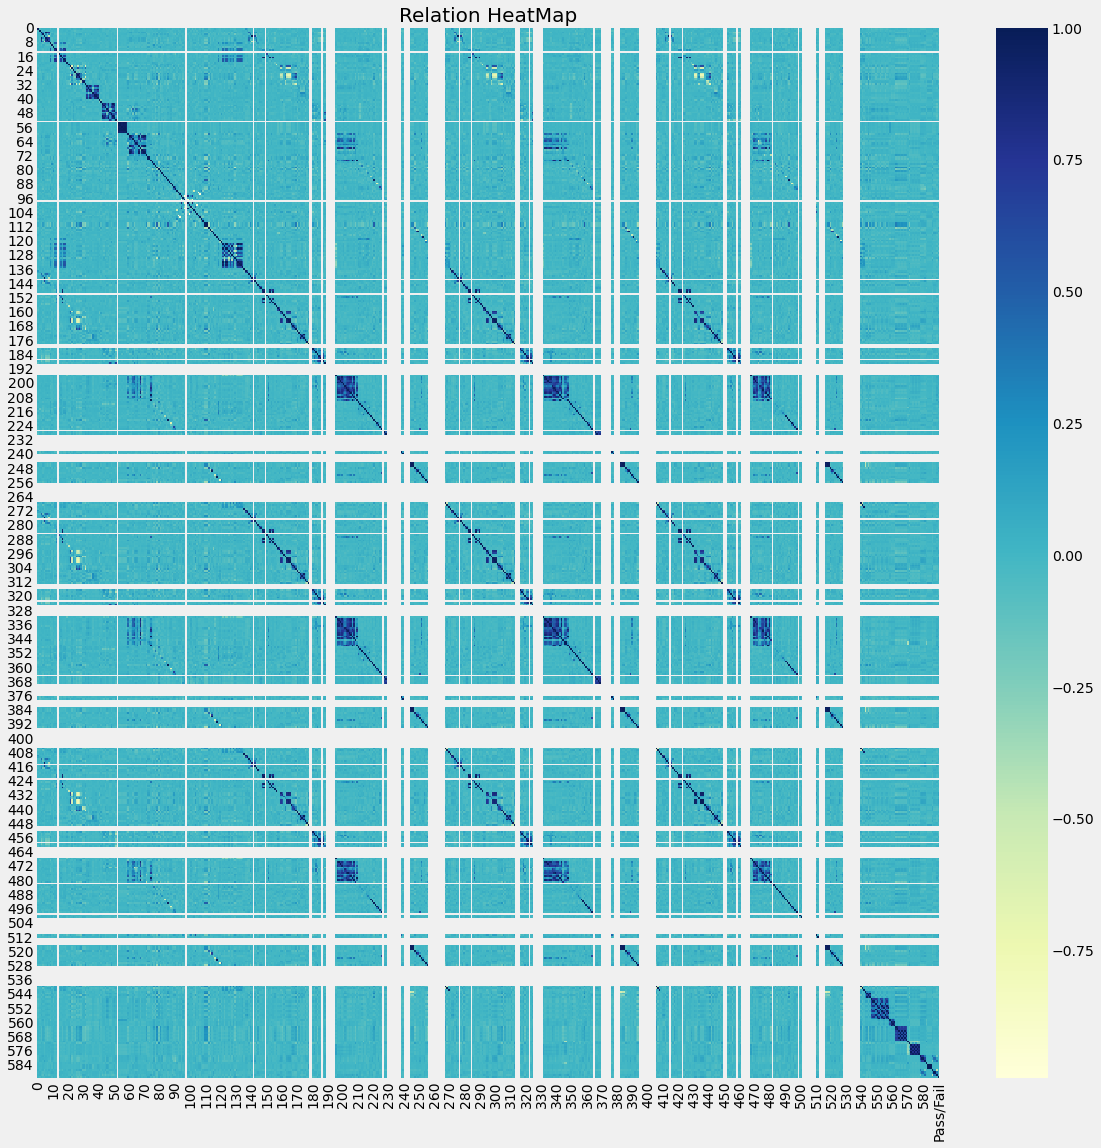

In [ ]:
plt.rcParams['figure.figsize'] = (18,18)
sns.heatmap(data.corr(), cmap='YlGnBu')
plt.title('Relation HeatMap', fontsize= 20)

<h2> Relation Values

입력한 상관계수 threshold 에 따라 feature들 필터링

In [ ]:
data.corr()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,1.000000,-0.047782,0.007590,0.009448,-0.000915,0.008706,0.006129,0.010738,-0.050979,0.009959,...,-0.033622,0.010503,0.019840,0.017889,0.019522,0.044745,0.005233,0.003918,0.021489,0.006149
1,-0.047782,1.000000,-0.030448,0.006021,0.002192,-0.030127,-0.031616,-0.025086,0.027609,0.003704,...,0.043107,-0.017392,0.003809,0.004409,0.003821,-0.009219,0.039479,0.040500,0.044464,-0.019672
2,0.007590,-0.030448,1.000000,0.323782,0.020438,0.990089,0.818770,0.747230,0.002600,-0.045731,...,0.038416,-0.010627,-0.004771,-0.003030,-0.004263,0.015733,-0.007090,-0.009122,-0.030434,0.024929
3,0.009448,0.006021,0.323782,1.000000,-0.054015,0.286397,-0.119180,0.279646,-0.108217,0.051567,...,0.000922,0.009788,0.022593,0.022361,0.023288,0.038755,-0.038371,-0.033648,-0.084449,-0.016341
4,-0.000915,0.002192,0.020438,-0.054015,1.000000,0.007041,-0.034736,-0.475861,-0.020082,0.053859,...,0.107783,0.012778,-0.001323,-0.001605,-0.001636,-0.043693,-0.030930,-0.026046,0.050741,-0.013577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,0.044745,-0.009219,0.015733,0.038755,-0.043693,0.019435,-0.005877,0.051943,0.017642,0.032423,...,-0.206109,-0.008240,0.002391,0.001602,0.002872,1.000000,0.169634,0.165942,-0.484741,0.004448
587,0.005233,0.039479,-0.007090,-0.038371,-0.030930,-0.003077,0.016362,-0.006335,0.027655,0.057856,...,0.227096,0.018981,-0.001809,-0.001696,-0.002122,0.169634,1.000000,0.974332,0.391503,0.035670
588,0.003918,0.040500,-0.009122,-0.033648,-0.026046,-0.004919,0.013832,-0.014288,0.033729,0.059321,...,0.216292,0.019083,-0.001445,-0.001182,-0.001746,0.165942,0.974332,1.000000,0.389898,0.031447
589,0.021489,0.044464,-0.030434,-0.084449,0.050741,-0.026117,0.002246,-0.067263,-0.016895,0.004106,...,0.431632,0.028502,-0.002453,-0.002750,-0.003266,-0.484741,0.391503,0.389898,1.000000,-0.002472


In [ ]:
def remove_collinear_features(x, threshold):
  corr_matrix = x.corr()
  iters = range(len(corr_matrix.columns) -1)
  drop_cols = []

  for i in iters:
    for j in range(i+1):

      item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
      col = item.columns
      row = item.index
      val = abs(item.values)

      if val >= threshold:
        print(col.values[0], 'Col ', row.values[0], '& Row Relation Values : ',round(val[0][0],2))
        drop_cols.append(col.values[0])

  drops = set(drop_cols)
  x = x.drop(columns=drops)

  return x

In [ ]:
threshold = 0.70
data = remove_collinear_features(data, threshold)

5 Col  2 & Row Relation Values :  0.99
6 Col  2 & Row Relation Values :  0.82
6 Col  5 & Row Relation Values :  0.84
7 Col  2 & Row Relation Values :  0.75
7 Col  5 & Row Relation Values :  0.77
12 Col  11 & Row Relation Values :  0.83
17 Col  11 & Row Relation Values :  0.81
18 Col  11 & Row Relation Values :  0.72
18 Col  12 & Row Relation Values :  0.79
18 Col  17 & Row Relation Values :  0.9
22 Col  21 & Row Relation Values :  0.75
26 Col  25 & Row Relation Values :  0.83
27 Col  25 & Row Relation Values :  0.98
27 Col  26 & Row Relation Values :  0.79
30 Col  29 & Row Relation Values :  0.86
34 Col  32 & Row Relation Values :  0.88
35 Col  34 & Row Relation Values :  0.83
37 Col  32 & Row Relation Values :  0.75
37 Col  34 & Row Relation Values :  0.75
38 Col  32 & Row Relation Values :  0.72
38 Col  34 & Row Relation Values :  0.72
38 Col  36 & Row Relation Values :  0.71
38 Col  37 & Row Relation Values :  0.97
39 Col  32 & Row Relation Values :  0.81
39 Col  34 & Row Relation V

<h2> Create a ML input data

In [ ]:
data = data.drop(columns=['Time'], axis = 1)

In [ ]:
data.shape

(1567, 307)

In [ ]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


# Dealing with Target Feature Imbalanced Problem Issues

<h2> Under Sampling

In [ ]:
failed_tests = data[data['Pass/Fail'] == 1]
number_failed_tests = len(failed_tests)
print(number_failed_tests)

104


In [ ]:
normal_indices = data[data['Pass/Fail'] == -1]
number_normal_indices = len(normal_indices)
print(number_normal_indices)

1463


In [ ]:
random_normal_indices = normal_indices.sample(n=number_failed_tests, replace=False)
print(random_normal_indices)

            0        1          2          3       4       8       9      10  \
960   3034.43  2586.86  2197.3222  1586.9476  2.0983  1.5842 -0.0143  0.0049   
92    3039.93  2447.89  2246.4889  1006.9548  1.0997  1.5414 -0.0095 -0.0167   
655   3083.33  2440.21  2171.8556   940.9917  1.2906  1.4821 -0.0171  0.0073   
1379  3043.32  2494.82  2206.4000   982.5452  1.1853  1.4454  0.0071  0.0073   
1420  2975.74  2517.35  2162.5556  1041.0369  1.4305  1.4968 -0.0201 -0.0060   
...       ...      ...        ...        ...     ...     ...     ...     ...   
476   3046.93  2459.21  2179.0778  1820.0613  1.6746  1.4633  0.0204 -0.0066   
330   2915.83  2526.29  2197.6778  1056.7817  1.3168  1.5091 -0.0064  0.0044   
688   2951.67  2521.41  2165.8666   847.7976  1.4274  1.3636 -0.0236 -0.0121   
1274  3021.37  2523.94  2209.1000  1244.9641  1.3724  1.4794 -0.0019 -0.0014   
467   3044.88  2636.69  2230.7555  1281.7862  1.0038  1.4868 -0.0325  0.0003   

          11   13  ...       570     57

In [ ]:
under_sample = np.concatenate([failed_tests.index, random_normal_indices.index])
print(len(under_sample))

208


In [ ]:
undersample_data = data.iloc[under_sample, :]

In [ ]:
undersample_data['Pass/Fail'].value_counts()

 1    104
-1    104
Name: Pass/Fail, dtype: int64

In [ ]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail']
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [ ]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state=1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [ ]:
sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)

In [ ]:
x_test_us = sc.transform(x_test_us)

<h2> Over sampling useing SMOTE

In [ ]:
x_resample, y_resample = SMOTE(random_state=1).fit_resample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(208, 306)
(208,)


In [ ]:
x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size=0.3, random_state=1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [ ]:
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

# ML Modeling

<h2> Data Preparation

In [ ]:
x = data.iloc[:, :(data.shape[1]-1)]
y = data['Pass/Fail']

print('shape of x : ', x.shape)
print('shape of y : ', y.shape)

shape of x :  (1567, 306)
shape of y :  (1567,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)

print('shape of x_train : ',x_train.shape)
print('shape of x_test : ',x_test.shape)
print('shape of y_train : ',y_train.shape)
print('shape of y_test : ',y_test.shape)

shape of x_train :  (1096, 306)
shape of x_test :  (471, 306)
shape of y_train :  (1096,)
shape of y_test :  (471,)


<h2> Classifier and Grid Search

# Feature Scalling

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# XGBoost (Scaled Data)

In [ ]:
xg = XGBClassifier(random_state = 1)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)

## Counfusion Matrix

<AxesSubplot:>

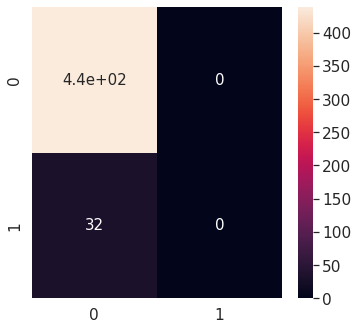

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5,5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':15})

In [ ]:
print('Accuracy : ', xg.score(x_test,y_test)*100)

Accuracy :  93.20594479830149


# RandomForest Scaled Data

In [ ]:
rf = RandomForestClassifier(n_estimators= 100, random_state=1, verbose = 0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

## Confusion Matrix

<AxesSubplot:>

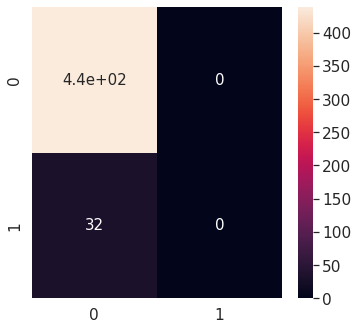

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize']=(5,5)
sns.set(style = 'dark', font_scale=1.4)
sns.heatmap(cm, annot = True, annot_kws = {'size' : 15})

In [ ]:
print('Accuracy : ',rf.score(x_test, y_test)*100)

Accuracy :  93.20594479830149


# Logistic Regression Scaled Data

In [ ]:
lr = LogisticRegression(random_state =1)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

## Confusion Matrix

<AxesSubplot:>

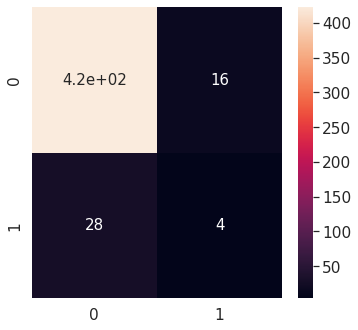

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5,5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':15})

In [ ]:
print('Accuracy : ',lr.score(x_test, y_test) * 100)

Accuracy :  90.65817409766454


# Lasso Scaled Data

In [ ]:
lasso = Lasso(alpha = 0.1, random_state=1)
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)

In [ ]:
y_pred2 = np.sign(y_pred)

In [ ]:
print('Accuracy : ' ,lasso.score(x_test, y_test)*100)

Accuracy :  -0.007974076019068299


## Confusion Matrix

<AxesSubplot:>

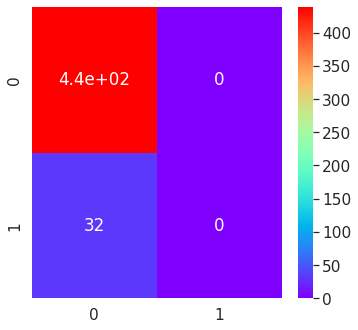

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='rainbow')

# Under Sampling Data RE Modeling

## XGBoost Undersampled Data

In [ ]:
model = XGBClassifier(random_state = 1)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## Confusion Matrix

<AxesSubplot:>

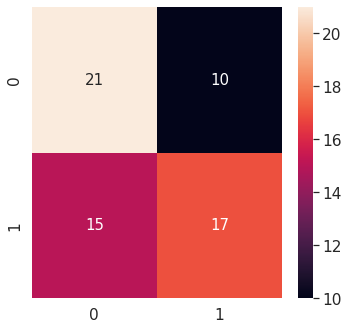

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize']=(5,5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws = {'size':15})

In [ ]:
print('Accuracy : ',model.score(x_test, y_test)*100)

Accuracy :  54.14012738853503


# Grid Search - XGBoost Undersampled Data

In [ ]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Best Accuracy : ', best_accuracy*100)
print('Best Parameter : ', best_parameters)

Best Accuracy :  62.06896551724138
Best Parameter :  {'cv': 2, 'max_depth': 1, 'random_state': 1}


In [ ]:
weights = (y==0).sum()/(1.0 *(y==-1).sum())

model = XGBClassifier(max_depth=3, scale_pos_weights = weights, n_jobs = 4, random_state = 1, cv=2 )
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)


In [ ]:
weights = (y==0).sum()/(1.0*(y==-1).sum())

model = XGBClassifier(max_depth = 3, scale_pos_weights = weights, n_jobs = 4, random_state = 1, cv = 2)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Accuracy : ',model.score(x_test, y_test)*100)

Accuracy :  54.14012738853503


# Confusion Matrix

<AxesSubplot:>

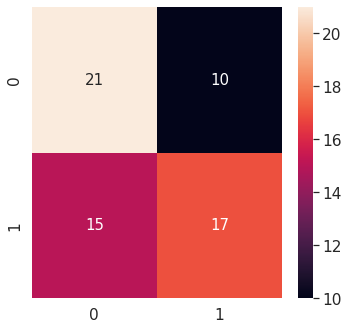

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5,5)
sns.set(style='dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {'size' : 15})

# Random Forest Under Sampled

In [ ]:
model = RandomForestClassifier(n_estimators = 100, random_state= 1, verbose = 0)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

<ipython-input-67-6536fbca86fa>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



# Confusion Matrix

<AxesSubplot:>

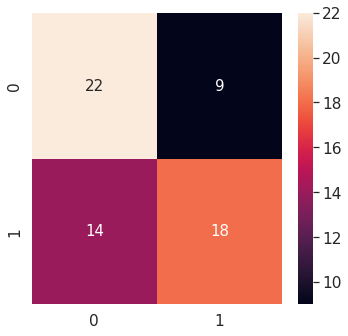

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5,5)
sns.set(style = 'dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws = {'size':15})

In [ ]:
print('Accuracy : ', model.score(x_test, y_test)*100)

Accuracy :  57.74946921443737


# Logistic Regression UnderSampled

In [ ]:
lr = LogisticRegression(random_state = 1)
lr.fit(x_train_us, y_train_us)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(random_state=1)

In [ ]:
y_pred = lr.predict(x_test_us)

# Confusion Matrix for Logistic Regression UnderSampled

<AxesSubplot:>

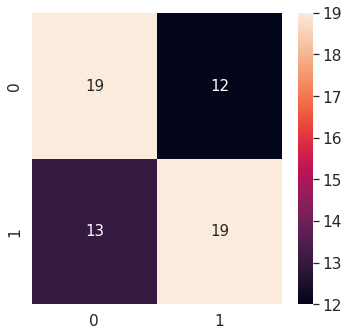

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5,5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot=True, annot_kws = {'size' : 15})

In [ ]:
print('Accuracy : ', lr.score(x_test, y_test) * 100)

Accuracy :  54.77707006369427


# Lasso UnderSampled

In [ ]:
lasso = Lasso(alpha = 0.1, random_state = 1)
lasso.fit(x_train_us, y_train_us)

Lasso(alpha=0.1, random_state=1)

In [ ]:
y_pred = lasso.predict(x_test_us)

In [ ]:
print(y_pred)

[ 0.31423186 -0.46362607  0.15620733  0.05325485 -0.28741533 -0.11974363
 -0.14229594  0.33710921 -0.23959     0.02999943  0.2386638  -0.32243655
 -0.22912472  0.22305407 -0.02684078 -0.25503793  0.0659873  -0.40539404
  0.67448981 -0.00563355 -0.72999477  0.19716875 -0.2547143   0.84708332
 -0.36784892  0.81704494  0.05826851  0.07628917  0.02944675 -0.51144821
 -0.17648097 -0.03072938 -0.09941557  0.15665497 -0.45305865  0.2133277
 -0.20461526  0.44727449  0.38960517 -0.25808436 -0.16403669 -0.32437405
  0.25679026 -0.32110604  0.14875097 -0.56510537  0.16979279  0.17770975
 -0.0150965   0.43064874 -0.27712428  0.26919618  0.01770025  0.3064431
 -0.06887109 -0.03038087 -0.07713243 -0.19779918 -0.09115132 -0.55432033
  0.02873826 -0.34861475  0.43909244]


In [ ]:
print(y_test_us)

      Pass/Fail
1281         -1
609          -1
143          -1
566          -1
495           1
...         ...
1302          1
273           1
1197         -1
361          -1
441           1

[63 rows x 1 columns]


In [ ]:
y_pred2 = np.sign(y_pred)

# Confusion Matrix

<AxesSubplot:>

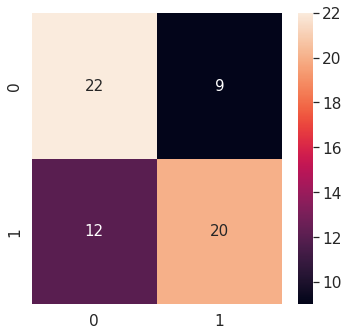

In [ ]:
cm = confusion_matrix(y_test_us, y_pred2)

plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [ ]:
print('Accuracy : ', lasso.score(x_test_us, y_test_us) * 100)

Accuracy :  8.453683824488634


# OverSampling Data Remodeling

# Grid Search - XGBoost (Oversampled)

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state = 1)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [{'max_depth' : [1,2,3,4,5,6],
               'cv' : [2,4,6,8,10],
               'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
print('Best Accuracy : ', best_accuracy)
print('Best Parameter : ', best_parameters)

Best Accuracy :  0.6206896551724138
Best Parameter :  {'cv': 2, 'max_depth': 1, 'random_state': 1}


In [ ]:
weights = (y==0).sum()/(1.0 *(y==-1).sum())

model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4, random_state=1, cv = 2)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



# Confusion Matrix

<AxesSubplot:>

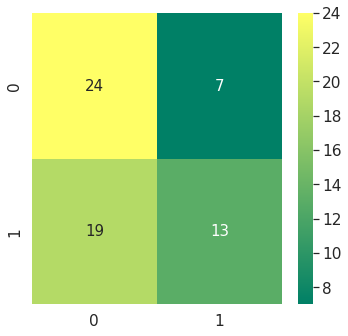

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)

plt.rcParams['figure.figsize'] = (5,5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size': 15}, cmap='summer')

In [ ]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  54.56475583864119


# Random Forest OverSamlped Data

In [ ]:
model = RandomForestClassifier(n_estimators = 100, random_state=1, verbose=0)
model.fit(x_train_os, y_train_os)
y_pred = model.predict(x_test_os)
print('Accuracy : ', model.score(x_test_os, y_test_os) * 100)

<ipython-input-92-e26bfb7085ff>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy :  63.49206349206349


# Confusion Matrix

<AxesSubplot:>

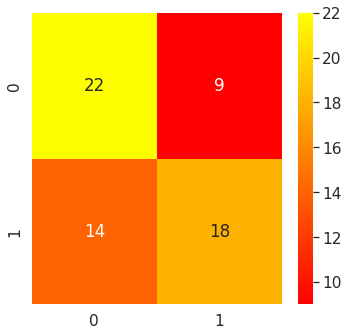

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot=True, cmap='autumn')

# Logistic Regression OverSampled Data

In [ ]:
lr = LogisticRegression(random_state = 1)
lr.fit(x_train_os, y_train_os)
y_pred = lr.predict(x_test_os)

print('Accuracy : ', lr.score(x_test_os, y_test_os)*100)

Accuracy :  60.317460317460316


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



# Confusion Matrix for Logistic Regression

<AxesSubplot:>

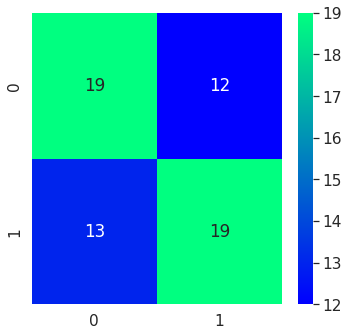

In [ ]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot=True, cmap =  'winter')

# Dimensionality reduction using PCA

In [ ]:
data.shape

(1567, 307)

# 1.Scailing using ZSCORE

In [ ]:
from scipy.stats import zscore
data_new = data.iloc[:,:306].apply(zscore)
data_new.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.436850,1.128343,-0.381523,-0.481360,NaN,...,-1.305710,0.190142,0.034410,-0.226018,-0.662093,0.055275,-0.204269,-1.734706,-1.868461,-1.061159
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.393723,0.022511,-1.608226,-0.011526,NaN,...,-1.305710,0.256816,1.205944,-0.261137,0.083539,0.162312,0.407145,-0.958144,0.412587,1.156951
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,-0.192349,0.327111,0.124224,-0.044305,NaN,...,5.447531,0.257279,-0.263745,-0.199823,3.873831,-0.304064,0.022827,2.989383,3.624211,-0.178407
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.300837,-0.765478,-0.370762,-0.006063,NaN,...,0.464315,0.002548,-0.278290,-0.221613,0.906840,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.465600,-0.149655,-0.790424,-0.169959,NaN,...,-1.305710,0.085279,-0.270290,-0.227409,-0.662093,-1.512057,26.860983,-0.100689,-0.177535,-0.274469


In [ ]:
data.isnull().any().any()

False

In [ ]:
data_new = data_new.replace(np.NaN, 0)

In [ ]:
data.isnull().any().any()

False

In [ ]:
x = data_new.iloc[:, :306]
y = data['Pass/Fail']

print('Shape of x:', x.shape)
print('Shape of y:', y.shape)

Shape of x: (1567, 306)
Shape of y: (1567,)


# PCA Step 1 - Create a Convariance Matrix

In [ ]:
cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

Covariance Matrix 
%s [[ 1.00063857 -0.04781282  0.00759455 ...  0.04477373  0.00523674
   0.02150242]
 [-0.04781282  1.00063857 -0.03046719 ... -0.00922529  0.03950455
   0.04449214]
 [ 0.00759455 -0.03046719  1.00063857 ...  0.01574304 -0.00709495
  -0.03045388]
 ...
 [ 0.04477373 -0.00922529  0.01574304 ...  1.00063857  0.16974222
  -0.48505059]
 [ 0.00523674  0.03950455 -0.00709495 ...  0.16974222  1.00063857
   0.39175294]
 [ 0.02150242  0.04449214 -0.03045388 ... -0.48505059  0.39175294
   1.00063857]]


# PCA Step 2 - Creates Eigen Values and Eigen Vector

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
print('Eigen Vectors \n%s', eig_vecs)
print('\n Eigen Values \n%s', eig_vals)

Eigen Vectors 
%s [[-0.0253695   0.008654   -0.00303277 ...  0.          0.
   0.        ]
 [-0.0025788  -0.00538507 -0.03440905 ...  0.          0.
   0.        ]
 [ 0.02753407 -0.00681287 -0.01400105 ...  0.          0.
   0.        ]
 ...
 [-0.048536    0.05395333 -0.04823939 ...  0.          0.
   0.        ]
 [ 0.01242541 -0.02265625  0.00838096 ...  0.          0.
   0.        ]
 [ 0.0256921  -0.06086426  0.04287574 ...  0.          0.
   0.        ]]

 Eigen Values 
%s [7.98315826 4.02662836 3.83340365 3.77872193 3.24842052 3.04338189
 2.81987221 2.70184859 2.63844411 2.49433697 2.39544185 2.33496444
 2.2688959  2.21004546 2.11987395 2.18253643 2.06331064 2.02389709
 2.01071359 1.99863763 1.98267329 1.95915582 1.92095551 1.8898469
 1.85708597 1.83222209 1.79047783 1.77162466 1.74830769 1.69223045
 1.6721054  1.59353955 1.61120278 1.64351825 1.63509768 1.58746461
 1.54878319 1.54342972 1.51376615 1.4987913  1.39927034 1.42330375
 1.46908609 1.45916185 1.45031371 1.37348926 1.3654

In [ ]:
tot = sum(eig_vals)
var_exp = [(i/tot) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('누적 분산 설명력 : ',cum_var_exp)

누적 분산 설명력 :  [  4.11240397   6.18666104   8.16138131  10.10793312  11.78130812
  13.34906055  14.80167533  16.19349202  17.55264684  18.83756703
  20.07154289  21.27436472  22.44315234  23.58162404  24.70592487
  25.79794607  26.86082953  27.90340969  28.93919857  29.96876671
  30.99011105  31.99934072  32.98889207  33.96241829  34.91906821
  35.86290988  36.78524762  37.69787343  38.59848786  39.47021494
  40.3315749   41.17820862  42.02050462  42.85049151  43.67137946
  44.48913799  45.28697037  46.08204499  46.86183886  47.63391867
  48.39069629  49.14236158  49.88946889  50.62266242  51.3434755
  52.05100785  52.75441472  53.44575446  54.13150394  54.80518611
  55.47224219  56.13386282  56.78335336  57.43035818  58.06247379
  58.68657041  59.30627663  59.91402001  60.51888826  61.11881541
  61.71313647  62.30277087  62.88054936  63.45680398  64.02642122
  64.58794689  65.14526769  65.69372362  66.23286709  66.7660594
  67.29318433  67.81743689  68.33600263  68.84838165  69.35881173

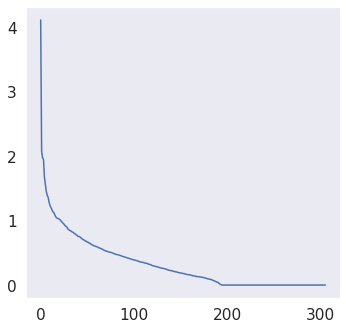

In [ ]:
plt.plot(var_exp)

Explained Variance Ratio : 각각의 주성분 벡터가 이루는 축에 투영한 결과의 분산의 비율 (= 각 eigenvalue의 비율)

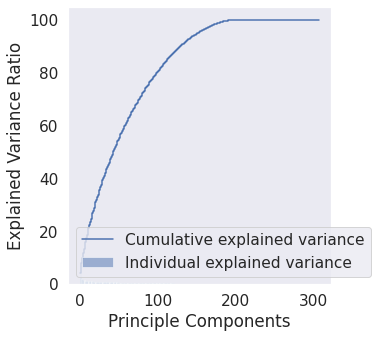

In [ ]:
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label='Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label ='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principle Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
len(cum_var_exp)

306

# Applying PCA with Scikit-learn

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=130)
data_reduced = pca.fit_transform(x)
data_reduced.transpose()

array([[ 3.26185437,  1.81271195,  2.21584218, ..., -5.38608444,
        -4.57165913, -5.28922777],
       [ 0.08026942,  0.84626441,  0.26213376, ..., 34.89726226,
         4.06175635, 35.38538007],
       [-0.21084772, -0.95972785, -1.19322826, ...,  3.05916747,
         2.00041888,  5.14353612],
       ...,
       [ 0.71599685,  0.06973093,  0.69720089, ..., -1.14713027,
        -0.64906809, -0.28797387],
       [-0.35877199,  0.72231619,  0.31483599, ..., -0.27911576,
         1.14617163, -0.77996922],
       [ 0.50729717, -0.45772977, -0.06861016, ...,  0.60231948,
        -0.46071469,  0.85074908]])

In [ ]:
pca.components_

array([[-0.02536951, -0.00257876,  0.027534  , ..., -0.04853598,
         0.01242541,  0.02569212],
       [-0.00865374,  0.00538594,  0.00681367, ..., -0.05395281,
         0.0226573 ,  0.06086365],
       [-0.00303196, -0.03440786, -0.01399851, ..., -0.04824025,
         0.00838132,  0.04287504],
       ...,
       [-0.04330223,  0.05401361, -0.00446949, ..., -0.00308971,
        -0.01395327,  0.0533495 ],
       [ 0.03854474,  0.01547232, -0.07922767, ...,  0.09116796,
         0.06070552, -0.01689081],
       [ 0.05258332,  0.01781091,  0.02735654, ..., -0.07162614,
        -0.06834629,  0.03623798]])

In [ ]:
df_comp = pd.DataFrame(pca.components_, columns=list(x))
df_comp.head()

,0,1,2,3,4,8,9,10,11,13,...,565,570,571,572,578,582,583,586,587,589
0,-0.025370,-0.002579,0.027534,-0.066608,-0.024699,0.077981,-0.031003,0.017991,-0.011328,-2.083309e-20,...,-0.103563,-0.017317,0.095065,-0.020350,-0.006380,-0.012915,0.006665,-0.048536,0.012425,0.025692
1,-0.008654,0.005386,0.006814,0.043184,0.000092,-0.217422,0.002423,0.042955,-0.307619,1.302382e-18,...,0.013688,-0.015340,0.029589,0.013741,0.039333,0.006928,0.006353,-0.053953,0.022657,0.060864
2,-0.003032,-0.034408,-0.013999,-0.003741,-0.003487,-0.062298,-0.011086,-0.037444,-0.033604,5.113004e-18,...,-0.032972,-0.007388,-0.011176,-0.008236,-0.029704,-0.048941,0.013378,-0.048240,0.008381,0.042875
3,-0.011014,0.019494,0.031017,0.008148,0.037434,0.027089,-0.034176,0.030428,0.011601,-3.223683e-19,...,0.042445,-0.031513,-0.018139,0.031902,0.048756,0.010023,0.018019,0.021472,-0.018802,-0.007801
4,-0.001611,-0.024105,-0.050007,-0.037771,-0.030997,0.003803,-0.003769,-0.000663,-0.092509,2.361315e-18,...,-0.051727,-0.022408,0.033651,0.025763,-0.102887,-0.021629,-0.015482,0.035708,-0.088354,-0.083101


<AxesSubplot:>

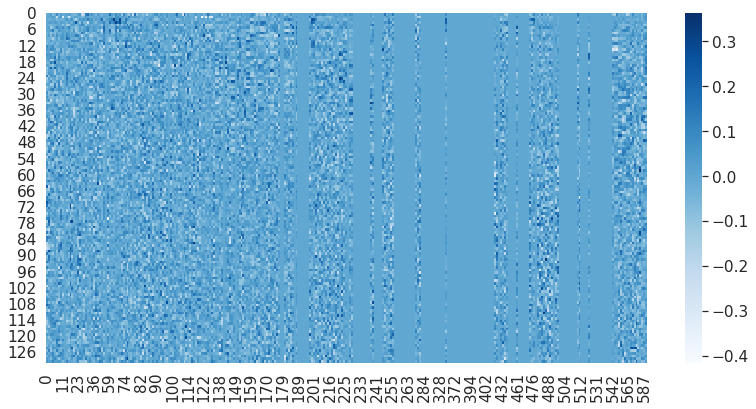

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp, cmap='Blues')

PCA 적용된 데이터 탐색

In [ ]:
data_reduced.shape

(1567, 130)

In [ ]:
df_red2 = pd.DataFrame(data_reduced)
df_red2.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,3.261854,0.080269,-0.210848,-0.872197,-0.618791,0.753694,-0.013372,-0.573209,-3.189598,1.888606,...,0.227220,-0.265535,1.038874,-0.829397,-0.450325,-0.148929,-0.039195,0.715997,-0.358772,0.507297
1,1.812712,0.846264,-0.959728,-0.070861,0.165039,0.658296,-1.083483,0.301690,-2.560141,1.301588,...,0.112359,0.518573,0.351080,-0.551831,1.213140,0.463021,1.135193,0.069731,0.722316,-0.457730
2,2.215842,0.262134,-1.193228,2.265446,-1.239635,-0.951116,2.025412,0.906439,-1.153554,-1.809367,...,-0.700767,0.271972,-0.988014,-0.729450,0.587933,0.196664,1.437451,0.697201,0.314836,-0.068610
3,3.617125,0.816797,-0.816703,2.151751,-2.612974,-1.409676,1.173411,0.842501,-0.293737,-2.765221,...,-1.531344,-0.425741,4.129739,4.701519,-0.788261,0.851923,-1.422492,0.115112,-0.119462,-0.628333
4,2.765991,0.133820,1.444556,2.270390,-1.498004,-0.623875,-2.928308,-1.895533,2.506712,1.484471,...,0.150122,-0.321296,0.381297,0.696150,-0.525744,0.036396,0.457067,-0.297790,-0.713580,-0.673779


Pass/Fail 데이터 합치기

In [ ]:
df_red3 = df_red2.copy()
df_red4 = df_red3
df_red4['Pass/Fail'] = data['Pass/Fail']

In [ ]:
df_red4.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,Pass/Fail
0,3.261854,0.080269,-0.210848,-0.872197,-0.618791,0.753694,-0.013372,-0.573209,-3.189598,1.888606,...,-0.265535,1.038874,-0.829397,-0.450325,-0.148929,-0.039195,0.715997,-0.358772,0.507297,-1
1,1.812712,0.846264,-0.959728,-0.070861,0.165039,0.658296,-1.083483,0.301690,-2.560141,1.301588,...,0.518573,0.351080,-0.551831,1.213140,0.463021,1.135193,0.069731,0.722316,-0.457730,-1
2,2.215842,0.262134,-1.193228,2.265446,-1.239635,-0.951116,2.025412,0.906439,-1.153554,-1.809367,...,0.271972,-0.988014,-0.729450,0.587933,0.196664,1.437451,0.697201,0.314836,-0.068610,1
3,3.617125,0.816797,-0.816703,2.151751,-2.612974,-1.409676,1.173411,0.842501,-0.293737,-2.765221,...,-0.425741,4.129739,4.701519,-0.788261,0.851923,-1.422492,0.115112,-0.119462,-0.628333,-1
4,2.765991,0.133820,1.444556,2.270390,-1.498004,-0.623875,-2.928308,-1.895533,2.506712,1.484471,...,-0.321296,0.381297,0.696150,-0.525744,0.036396,0.457067,-0.297790,-0.713580,-0.673779,-1


In [ ]:
df_red4.shape

(1567, 131)

# Drop outlier

Pass/Fail 별 PCA 데이터의 이상치 탐색

array([[<AxesSubplot:title={'center':'0'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'2'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'3'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'4'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'5'}, xlabel='Pass/Fail'>]],
      dtype=object)

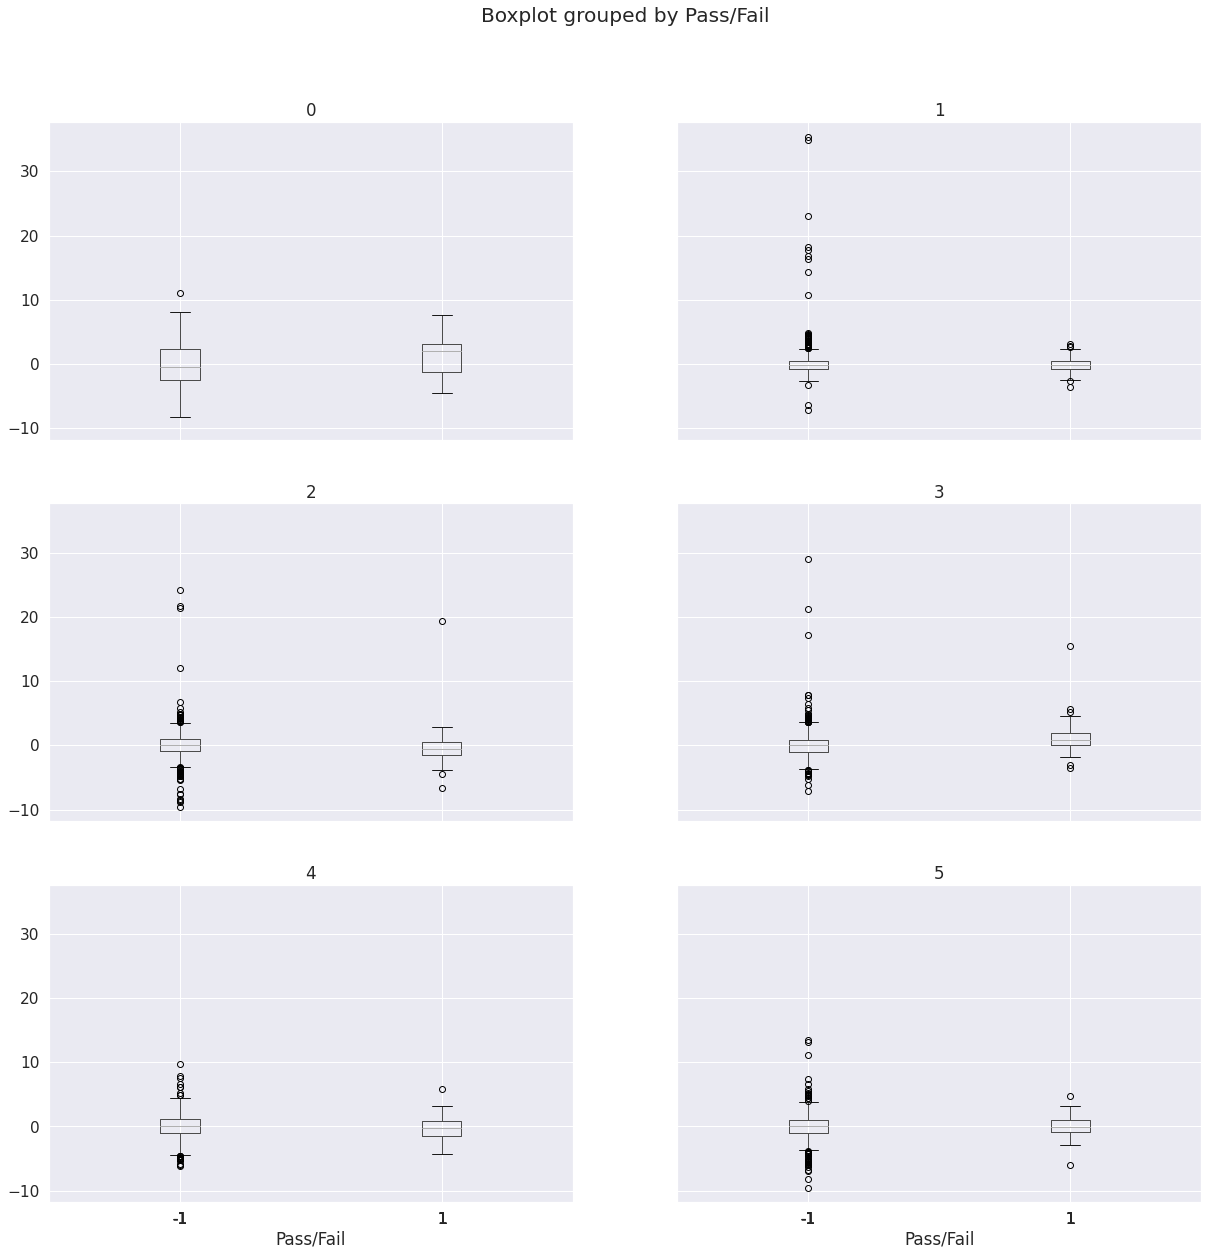

In [ ]:
df_red4.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3],
                          df_red4.columns[4],
                          df_red4.columns[5],],
                by = 'Pass/Fail', figsize=(20,20))

이상치 제거 적용 Quantile, IQR 사용

In [ ]:
pd_data = df_red4.copy()

from scipy import stats

def outlier_removal_max(var):
  var = np.where(var > var.quantile(0.75) + stats.iqr(var), var.quantile(0.50), var)
  return var

def outlier_removal_min(var):
  var = np.where(var < var.quantile(0.25) - stats.iqr(var), var.quantile(0.50), var)
  return var

for column in pd_data:
  pd_data[column] = outlier_removal_max(pd_data[column])
  pd_data[column] = outlier_removal_min(pd_data[column])

array([[<AxesSubplot:title={'center':'0'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'1'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'2'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'3'}, xlabel='Pass/Fail'>],
       [<AxesSubplot:title={'center':'4'}, xlabel='Pass/Fail'>,
        <AxesSubplot:title={'center':'5'}, xlabel='Pass/Fail'>]],
      dtype=object)

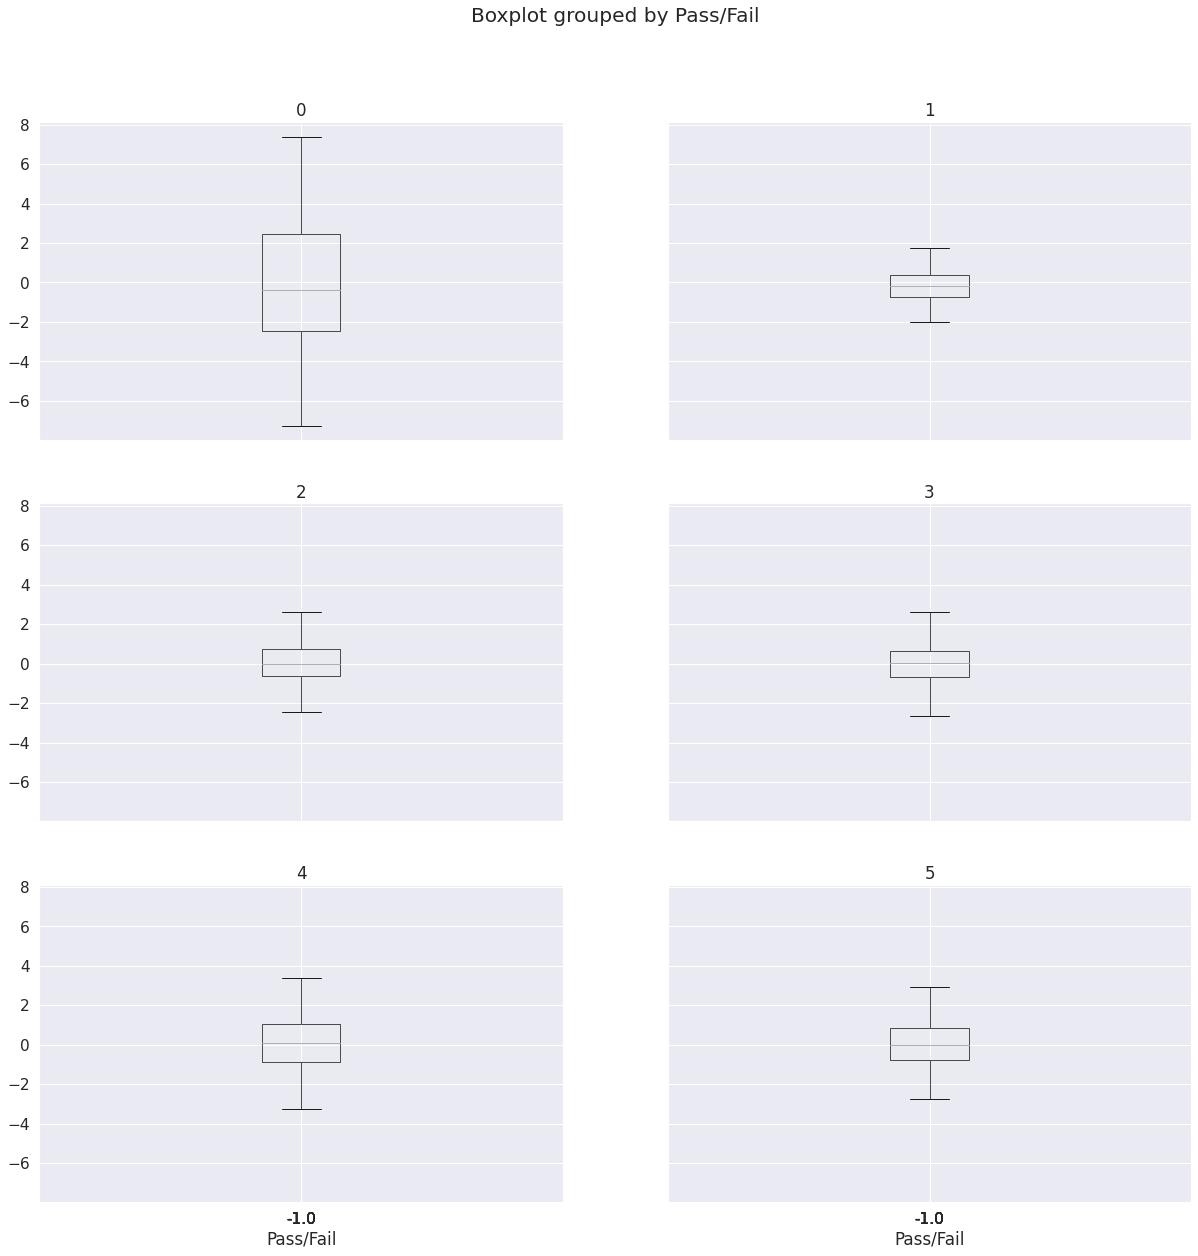

In [ ]:
pd_data.boxplot(column = [df_red4.columns[0],
                          df_red4.columns[1],
                          df_red4.columns[2],
                          df_red4.columns[3],
                          df_red4.columns[4],
                          df_red4.columns[5],],
                by = 'Pass/Fail', figsize=(20,20))

# Apply PCA + Outliers Drop and Remodel Data

# 1. Under Sampling

In [ ]:
x = df_red4.iloc[:, df_red4.columns != 'Pass/Fail']
y = df_red4.iloc[:, df_red4.columns == 'Pass/Fail']

print('shape of x : ', x.shape)
print('shape of y : ', y.shape)

shape of x :  (1567, 130)
shape of y :  (1567, 1)


In [ ]:
failed_tests = np.array(df_red4[df_red4['Pass/Fail']==1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [ ]:
normal_indices = df_red4[df_red4['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

In [ ]:
print(no_normal_indices)

1463


In [ ]:
random_normal_indices = np.random.choice(no_normal_indices, size=no_failed_tests, replace= True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [ ]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [ ]:
undersample_data = df_red4.iloc[under_sample, :]

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail']
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 130)
(208, 1)


In [ ]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 130)
(145, 1)
(63, 130)
(63, 1)


# XGBoost - PCA for Undersampled Data

In [ ]:
model = XGBClassifier(random_state=1)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



# Confusion Matrix

<AxesSubplot:>

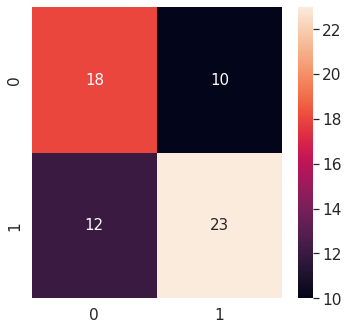

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize']=(5,5)
sns.set(style='dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':15})

In [ ]:
print('Accuracy : ', model.score(x_test_us,y_test_us)*100)

Accuracy :  65.07936507936508


# Grid Search - XGBoost - PCA for UnderSampled Data

In [ ]:
parameters = [{'max_depth' : [1,2,3,4,5,6],
               'cv' : [2,4,6,8,10],
               'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid=parameters, scoring='accuracy', n_jobs= -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy : ', best_accuracy*100)
print('Best Parameter : ', best_parameters)

Best Accuracy :  66.20689655172414
Best Parameter :  {'cv': 2, 'max_depth': 5, 'random_state': 1}


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
weights = (y==0).sum()/(1.0*(y==-1).sum())

model = XGBClassifier(max_depth = 5, scale_pos_weights = weights, n_jobs = 5, random_state=1, cv = 2)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

print('Accuracy : ', model.score(x_test_us, y_test_us)*100)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy :  60.317460317460316


# Confusion Matrix

<AxesSubplot:>

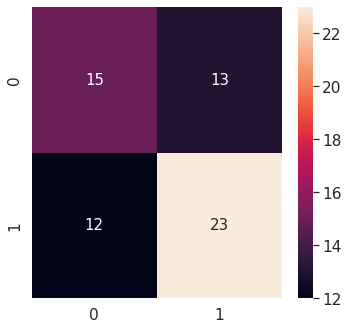

In [ ]:
cm = confusion_matrix(y_test_us, y_pred)

plt.rcParams['figure.figsize'] = (5,5)
sns.set(style = 'dark', font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={'size':15})

# Random Forest - PCA UnderSampled Data

<ipython-input-155-04d612f25a13>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



<AxesSubplot:>

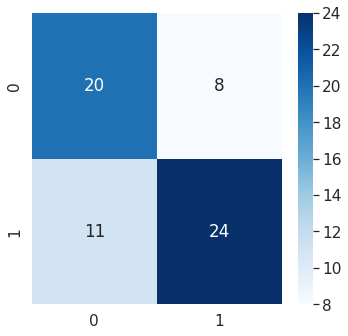

In [ ]:
model = RandomForestClassifier(n_estimators = 100, random_state = 1, verbose = 0)
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot=True, cmap = 'Blues')

In [ ]:
print('Accuracy : ', model.score(x_test_us, y_test_us)*100)

Accuracy :  69.84126984126983


# Logistic Regression - PCA for UnderSampled Data

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



<AxesSubplot:>

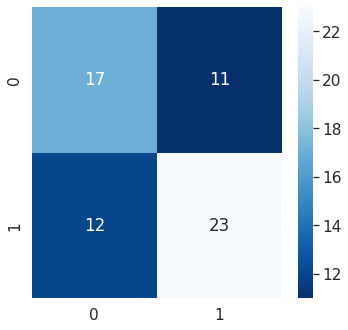

In [ ]:
lr = LogisticRegression(random_state = 1)
lr.fit(x_train_us, y_train_us)
y_pred = lr.predict(x_test_us)

cm = confusion_matrix(y_test_us, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues_r')

In [ ]:
print('Accuracy : ', model.score(x_test_us, y_test_us)*100 )

Accuracy :  69.84126984126983


# 4.Lasso - PCA for UnderSampled Data

In [ ]:
lasso = Lasso(alpha = 0.1, random_state=1)
lasso.fit(x_train_us, y_train_us)

y_pred = lasso.predict(x_test_us)

y_pred2 = np.sign(y_pred)

In [ ]:
actual_cost = list(y_test_us)
actual_cost = np.asarray(actual_cost)
y_pred_lasso = lasso.predict(x_test_us)

In [ ]:
print('Accuracy : ', lasso.score(x_test_us, y_test_us)*100)

Accuracy :  2.6693249648027884


# Confusion Matrix

<AxesSubplot:>

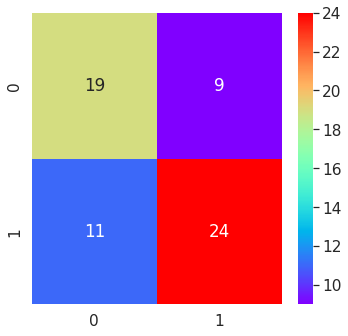

In [ ]:
cm = confusion_matrix(y_test_us, y_pred2)
sns.heatmap(cm, annot=True, cmap = 'rainbow')

# Feature Importances

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(x_train_us, y_train_us)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier()

In [ ]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

trace = go.Scatter(
    y = model.feature_importances_,
    x = x_train_us.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = model.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = x_train_us.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')